In [1]:
import os
import re
import numpy as np
import pandas as pd
from pprint import pprint


In [2]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [3]:
# spacy for lemmatization
import spacy

In [4]:
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt

In [5]:
%matplotlib inline

In [6]:
# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [7]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [8]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [9]:
# Import Dataset
df = pd.read_json('3w.json')
df.head()

,GENDER TROUBLE
0,GENDER TROUBLE
1,Feminism and the
2,Subversion of Identity
3,
4,


In [12]:
# Convert to list
data = df.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', str(sent)) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['[\\x0c\\x0cGENDER TROUBLE]']


In [13]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['cgender', 'trouble']]


In [14]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['cgender', 'trouble']


In [15]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [16]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['cgender', 'trouble']]


In [17]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

In [18]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [19]:
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['cgender', 'trouble']]


In [20]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1)]]


In [21]:
id2word[0]

'cgender'

In [22]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('cgender', 1), ('trouble', 1)]]

In [23]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [24]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.127*"see" + 0.032*"sex" + 0.029*"issue" + 0.024*"edit" + 0.019*"example" '
  '+ 0.015*"discover" + 0.015*"offer" + 0.014*"order" + 0.013*"mass" + '
  '0.013*"try"'),
 (1,
  '0.071*"family" + 0.029*"husband" + 0.027*"come" + 0.026*"get" + '
  '0.025*"foster" + 0.025*"leave" + 0.022*"reprint" + 0.020*"hour" + '
  '0.020*"report" + 0.018*"human"'),
 (2,
  '0.512*"woman" + 0.080*"man" + 0.032*"first" + 0.028*"negro" + '
  '0.017*"accord" + 0.013*"must" + 0.007*"communist" + 0.006*"learn" + '
  '0.006*"face" + 0.006*"establish"'),
 (3,
  '0.105*"housework" + 0.089*"quote" + 0.080*"rape" + 0.039*"racism" + '
  '0.028*"racist" + 0.025*"society" + 0.022*"writing" + 0.017*"second" + '
  '0.017*"rise" + 0.016*"system"'),
 (4,
  '0.092*"home" + 0.039*"wife" + 0.035*"include" + 0.034*"press" + '
  '0.033*"know" + 0.031*"essential" + 0.028*"government" + 0.021*"place" + '
  '0.016*"exploitation" + 0.012*"era"'),
 (5,
  '0.144*"history" + 0.044*"capitalist" + 0.025*"young" + 0.024*"girl" +

In [26]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis


Perplexity:  -11.143417677301613

Coherence Score:  0.634723545238693


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
14     0.001078  0.208929       1        1  8.285805
2      0.397919  0.009504       2        1  7.752922
7     -0.009232  0.092770       3        1  7.455608
16     0.004790 -0.058958       4        1  5.668062
12    -0.013696 -0.004433       5        1  5.397001
11    -0.032586  0.022746       6        1  5.110437
9     -0.003211 -0.002861       7        1  5.101799
13    -0.024320  0.005985       8        1  4.628089
19    -0.023039  0.015915       9        1  4.541967
18    -0.030612 -0.002116      10        1  4.495077
0     -0.037080  0.033141      11        1  4.453933
3      0.003699 -0.298816      12        1  4.379755
5     -0.026272  0.013530      13        1  4.317672
10    -0.022682  0.001540      14        1  4.277966
17    -0.037846  0.012109      15        1  4.260227
8     -0.028735 -0.015947      16        1  4.232369
6     -0.027817 -0.004756      17        1  4.208683
1     -0.026813 -0.013505      18        1  3.990889
15    -0.030235 -0.003628      19        1  3.891377
4     -0.033308 -0.011149      20        1  3.550361, topic_info=     Category         Freq           Term        Total  loglift  logprob
term                                                                    
58    Default  2655.000000          woman  2655.000000  30.0000  30.0000
4706  Default   957.000000          black   957.000000  29.0000  29.0000
275   Default   496.000000           work   496.000000  28.0000  28.0000
4708  Default   486.000000          white   486.000000  27.0000  27.0000
1401  Default   416.000000        history   416.000000  26.0000  26.0000
710   Default   379.000000            see   379.000000  25.0000  25.0000
482   Default   414.000000            man   414.000000  24.0000  24.0000
235   Default   389.000000           also   389.000000  23.0000  23.0000
5009  Default   308.000000      housework   308.000000  22.0000  22.0000
462   Default   302.000000         people   302.000000  21.0000  21.0000
131   Default   328.000000       movement   328.000000  20.0000  20.0000
5078  Default   258.000000         worker   258.000000  19.0000  19.0000
2872  Default   260.000000          quote   260.000000  18.0000  18.0000
101   Default   306.000000          would   306.000000  17.0000  17.0000
2325  Default   305.000000           wage   305.000000  16.0000  16.0000
660   Default   229.000000          labor   229.000000  15.0000  15.0000
4948  Default   234.000000           rape   234.000000  14.0000  14.0000
950   Default   219.000000           home   219.000000  13.0000  13.0000
5053  Default   240.000000       domestic   240.000000  12.0000  12.0000
5172  Default   218.000000      housewife   218.000000  11.0000  11.0000
13    Default   210.000000           book   210.000000  10.0000  10.0000
99    Default   255.000000           year   255.000000   9.0000   9.0000
3097  Default   210.000000          child   210.000000   8.0000   8.0000
6942  Default   202.000000          lynch   202.000000   7.0000   7.0000
948   Default   190.000000         family   190.000000   6.0000   6.0000
711   Default   195.000000        chapter   195.000000   5.0000   5.0000
87    Default   199.000000         sexual   199.000000   4.0000   4.0000
112   Default   183.000000           life   183.000000   3.0000   3.0000
8     Default   174.000000            new   174.000000   2.0000   2.0000
1890  Default   178.000000          slave   178.000000   1.0000   1.0000
...       ...          ...            ...          ...      ...      ...
2624  Topic20    92.223595           wife    93.283813   3.3267  -3.2482
26    Topic20    84.078598        include    85.138817   3.3256  -3.3407
4728  Topic20    81.441185          press    82.501404   3.3252  -3.3726
28    Topic20    79.098572           know    80.158791   3.3248  -3.4018
1223  Topic20    73.703506      essential    74.763725   3.3238  -3.4724
5318  Topic20    

In [28]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
14     0.001078  0.208929       1        1  8.285800
2      0.397919  0.009504       2        1  7.752923
7     -0.009232  0.092770       3        1  7.455610
16     0.004790 -0.058958       4        1  5.668060
12    -0.013696 -0.004433       5        1  5.397003
11    -0.032586  0.022746       6        1  5.110432
9     -0.003211 -0.002861       7        1  5.101798
13    -0.024320  0.005985       8        1  4.628092
19    -0.023039  0.015915       9        1  4.541969
18    -0.030612 -0.002116      10        1  4.495081
0     -0.037080  0.033141      11        1  4.453930
3      0.003699 -0.298816      12        1  4.379755
5     -0.026272  0.013530      13        1  4.317674
10    -0.022682  0.001540      14        1  4.277964
17    -0.037846  0.012109      15        1  4.260227
8     -0.028735 -0.015947      16        1  4.232363
6     -0.027817 -0.004756      17        1  4.208683
1     -0.026813 -0.013505      18        1  3.990891
15    -0.030235 -0.003628      19        1  3.891378
4     -0.033308 -0.011149      20        1  3.550364, topic_info=     Category         Freq           Term        Total  loglift  logprob
term                                                                    
58    Default  2655.000000          woman  2655.000000  30.0000  30.0000
4706  Default   957.000000          black   957.000000  29.0000  29.0000
275   Default   496.000000           work   496.000000  28.0000  28.0000
4708  Default   486.000000          white   486.000000  27.0000  27.0000
1401  Default   416.000000        history   416.000000  26.0000  26.0000
710   Default   379.000000            see   379.000000  25.0000  25.0000
482   Default   414.000000            man   414.000000  24.0000  24.0000
235   Default   389.000000           also   389.000000  23.0000  23.0000
5009  Default   308.000000      housework   308.000000  22.0000  22.0000
462   Default   302.000000         people   302.000000  21.0000  21.0000
131   Default   328.000000       movement   328.000000  20.0000  20.0000
5078  Default   258.000000         worker   258.000000  19.0000  19.0000
2872  Default   260.000000          quote   260.000000  18.0000  18.0000
101   Default   306.000000          would   306.000000  17.0000  17.0000
2325  Default   305.000000           wage   305.000000  16.0000  16.0000
660   Default   229.000000          labor   229.000000  15.0000  15.0000
4948  Default   234.000000           rape   234.000000  14.0000  14.0000
950   Default   219.000000           home   219.000000  13.0000  13.0000
5053  Default   240.000000       domestic   240.000000  12.0000  12.0000
5172  Default   218.000000      housewife   218.000000  11.0000  11.0000
13    Default   210.000000           book   210.000000  10.0000  10.0000
99    Default   255.000000           year   255.000000   9.0000   9.0000
3097  Default   210.000000          child   210.000000   8.0000   8.0000
6942  Default   202.000000          lynch   202.000000   7.0000   7.0000
948   Default   190.000000         family   190.000000   6.0000   6.0000
711   Default   195.000000        chapter   195.000000   5.0000   5.0000
87    Default   199.000000         sexual   199.000000   4.0000   4.0000
112   Default   183.000000           life   183.000000   3.0000   3.0000
8     Default   174.000000            new   174.000000   2.0000   2.0000
1890  Default   178.000000          slave   178.000000   1.0000   1.0000
...       ...          ...            ...          ...      ...      ...
2624  Topic20    92.223648           wife    93.283867   3.3267  -3.2482
26    Topic20    84.078636        include    85.138855   3.3256  -3.3407
4728  Topic20    81.441231          press    82.501450   3.3252  -3.3726
28    Topic20    79.098618           know    80.158836   3.3248  -3.4018
1223  Topic20    73.703545      essential    74.763763   3.3238  -3.4724
5318  Topic20    

In [33]:
mallet_path = '/Users/administrador/Downloads/mallet-2.0.8/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [34]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(3,
  [('object', 0.047094188376753505),
   ('word', 0.03807615230460922),
   ('person', 0.025050100200400802),
   ('write', 0.02404809619238477),
   ('love', 0.023714094856379427),
   ('result', 0.02338009352037408),
   ('reality', 0.02171008684034736),
   ('state', 0.02137608550434202),
   ('real', 0.0197060788243153),
   ('read', 0.01903807615230461)]),
 (9,
  [('claim', 0.04226336011177087),
   ('follow', 0.026545581557806498),
   ('race', 0.025847013622074748),
   ('find', 0.02444987775061125),
   ('drive', 0.023052741879147746),
   ('campaign', 0.023052741879147746),
   ('understand', 0.022703457911281873),
   ('critical', 0.021655606007684246),
   ('present', 0.021655606007684246),
   ('vote', 0.020607754104086624)]),
 (12,
  [('law', 0.08017591339648174),
   ('female', 0.06427604871447902),
   ('male', 0.03484438430311231),
   ('labor', 0.029093369418132613),
   ('begin', 0.023004059539918808),
   ('free', 0.02266576454668471),
   ('emerge', 0.02097428958051421),
   ('society'

In [35]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [36]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

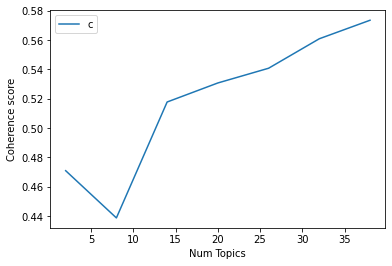

In [37]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [38]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4709
Num Topics = 8  has Coherence Value of 0.4387
Num Topics = 14  has Coherence Value of 0.5177
Num Topics = 20  has Coherence Value of 0.5307
Num Topics = 26  has Coherence Value of 0.5407
Num Topics = 32  has Coherence Value of 0.5608
Num Topics = 38  has Coherence Value of 0.5734


In [39]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.255*"woman" + 0.104*"work" + 0.033*"slavery" + 0.025*"campaign" + '
  '0.024*"field" + 0.023*"begin" + 0.020*"describe" + 0.019*"live" + '
  '0.017*"open" + 0.014*"day"'),
 (1,
  '0.094*"desire" + 0.048*"object" + 0.035*"mother" + 0.031*"word" + '
  '0.024*"love" + 0.020*"subject" + 0.018*"loss" + 0.017*"homosexual" + '
  '0.015*"sign" + 0.015*"original"'),
 (2,
  '0.079*"slave" + 0.045*"child" + 0.039*"family" + 0.033*"life" + '
  '0.029*"home" + 0.026*"case" + 0.023*"force" + 0.021*"free" + 0.017*"school" '
  '+ 0.016*"husband"'),
 (3,
  '0.114*"body" + 0.063*"female" + 0.042*"question" + 0.037*"social" + '
  '0.034*"suggest" + 0.028*"prior" + 0.023*"long" + 0.022*"signify" + '
  '0.021*"culture" + 0.021*"signification"'),
 (4,
  '0.090*"sexual" + 0.059*"term" + 0.042*"practice" + 0.029*"set" + '
  '0.029*"binary" + 0.025*"lesbian" + 0.024*"result" + 0.021*"experience" + '
  '0.018*"construct" + 0.015*"feminine"'),
 (5,
  '0.054*"understand" + 0.042*"position" + 0.040*"rela

In [41]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,8.0,0.0673,"gender, trouble, give, reality, operate, exist...",[\x0c\x0cGENDER TROUBLE]
1,1,5.0,0.0664,"understand, position, relation, structure, ass...",[Feminism and the]
2,2,8.0,0.0673,"gender, trouble, give, reality, operate, exist...",[Subversion of Identity]
3,3,0.0,0.0500,"woman, work, slavery, campaign, field, begin, ...",[]
4,4,0.0,0.0500,"woman, work, slavery, campaign, field, begin, ...",[]
5,5,0.0,0.0500,"woman, work, slavery, campaign, field, begin, ...",[]
6,6,0.0,0.0500,"woman, work, slavery, campaign, field, begin, ...",[]
7,7,4.0,0.0643,"sexual, term, practice, set, binary, lesbian, ...",[J UDITH B UTLER]
8,8,0.0,0.0500,"woman, work, slavery, campaign, field, begin, ...",[]
9,9,0.0,0.0500,"woman, work, slavery, campaign, field, begin, ...",[]


In [42]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.1351,"woman, work, slavery, campaign, field, begin, ...","[wrongs as compared to the wrongs of women, in..."
1,1.0,0.1339,"desire, object, mother, word, love, subject, l...","[mother as object of desire, the boy either in..."
2,2.0,0.1491,"slave, child, family, life, home, case, force,...","[largely an extension of family life. Thus, wo..."
3,3.0,0.1319,"body, female, question, social, suggest, prior...","[body lacks; hence, the body presents itself a..."
4,4.0,0.1204,"sexual, term, practice, set, binary, lesbian, ...",[into the terms of heterosexuality. As one les...


In [43]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,8.0,"gender, trouble, give, reality, operate, exist...",3412.0,0.2096
1,5.0,"understand, position, relation, structure, ass...",904.0,0.0555
2,8.0,"gender, trouble, give, reality, operate, exist...",813.0,0.0500
3,0.0,"woman, work, slavery, campaign, field, begin, ...",813.0,0.0500
4,0.0,"woman, work, slavery, campaign, field, begin, ...",784.0,0.0482
5,0.0,"woman, work, slavery, campaign, field, begin, ...",785.0,0.0482
6,0.0,"woman, work, slavery, campaign, field, begin, ...",655.0,0.0402
7,4.0,"sexual, term, practice, set, binary, lesbian, ...",718.0,0.0441
8,0.0,"woman, work, slavery, campaign, field, begin, ...",757.0,0.0465
9,0.0,"woman, work, slavery, campaign, field, begin, ...",635.0,0.0390
